# House pricing prediction
#### Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

##### With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

#### The objective of this project is to generate a prediction of the prices.Analyzing and cleaning the data prior to explore and define technique to model.

## Import libraries

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sb
from scipy import stats
from statsmodels.formula.api import ols
%matplotlib inline

### Load data

In [128]:
data=pd.read_csv("./data/train.csv")
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Analyze the objective column distribution and frequency. 

In [129]:
data["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

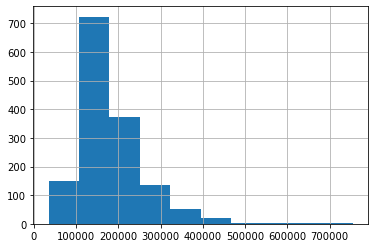

In [130]:
data["SalePrice"].hist()

##### Distribution do not look as a normal distribution. 

In [131]:
import scipy.stats as st
##obtained in stack overflow.
#this is to review which distribution fix better with our goal parameter.
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme","lognorm","beta","invgauss","uniform","gamma","expon","pearson3","triang"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]
get_best_distribution(data['SalePrice'])

p value for norm = 6.402139779190053e-20


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:1677: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +


p value for exponweib = 0.0
p value for weibull_max = 0.0
p value for weibull_min = 0.0
p value for pareto = 3.795561855165914e-227


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for genextreme = 0.0
p value for lognorm = 0.014705247778226238


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


p value for beta = 4.448638594770014e-06
p value for invgauss = 6.96903963660358e-219
p value for uniform = 0.0
p value for gamma = 0.0
p value for expon = 4.933205313206431e-109
p value for pearson3 = 7.101045838704336e-05
p value for triang = 3.534558675005082e-210
Best fitting distribution: lognorm
Best p value: 0.014705247778226238
Parameters for the best fit: (0.39897548872302213, -129.93222216110172, 166854.6998403497)


('lognorm',
 0.014705247778226238,
 (0.39897548872302213, -129.93222216110172, 166854.6998403497))

### This is a log normal distribution. Log normal can be transformed to Normal distribution.
https://www.youtube.com/watch/eAdfLxTsuRc
https://aegis4048.github.io/transforming-non-normal-distribution-to-normal-distribution


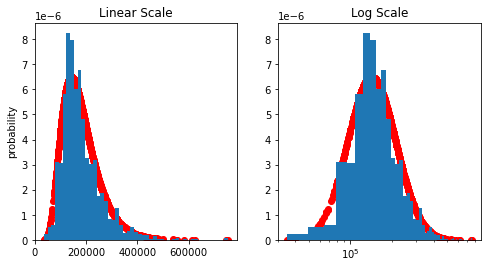

In [132]:
# fit lognormal distribution
SalePrice=data[["SalePrice"]].to_numpy()
shape, loc, scale = stats.lognorm.fit(SalePrice, loc=0)
pdf_lognorm = stats.lognorm.pdf(SalePrice, shape, loc, scale)
# visualize

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.hist(SalePrice, bins='auto', density=True)
ax1.scatter(SalePrice, pdf_lognorm, color = 'r')
ax1.set_ylabel('probability')
ax1.set_title('Linear Scale')

ax2.hist(SalePrice, bins='auto', density=True)
ax2.scatter(SalePrice, pdf_lognorm, color = 'r')
ax2.set_xscale('log')
ax2.set_title('Log Scale');

### Applying Boxcox transformation 

In [133]:
xt, lmbda = stats.boxcox(data["SalePrice"])
#Adding a new column
data["SalePriceLog"]=xt

##### Explore numerical data to clean.

In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [135]:
#Categorical
#print values of PoolQC
print(data['PoolQC'].unique())
#Assuming that nan refers to 'NA' which means No pool
data['PoolQC'] = data.PoolQC.fillna('NA')
#print values of PoolQC
print(data['MiscFeature'].unique())
#Assuming that nan refers to 'NA' which means No misc feature.
data['MiscFeature'] = data.MiscFeature.fillna('NA')
#print values for fence
print(data['Fence'].unique())
#Assuming that nan refers to 'NA' which means No fence.
data['Fence'] = data.Fence.fillna('NA')
#print values for Alley
print(data['Alley'].unique())
#Assuming that nan refers to 'NA' which means No alley access.
data['Alley'] = data.Alley.fillna('NA')
#print values for FireplaceQu
print(data['FireplaceQu'].unique())
#Assuming that nan refers to 'NA' which means No fire place.
data['FireplaceQu'] = data.FireplaceQu.fillna('NA')
#print values for Garage
print(data['GarageQual'].unique())
print(data['GarageCond'].unique()) 
print(data['GarageType'].unique())  
print(data['GarageFinish'].unique()) 
#Assuming that nan refers to 'NA' which means No Garage.
data['GarageQual'] = data.GarageQual.fillna('NA')
data['GarageCond'] = data.GarageCond.fillna('NA')
data['GarageType'] = data.GarageType.fillna('NA')
data['GarageFinish'] = data.GarageFinish.fillna('NA')

#print values for Basement
print(data['BsmtQual'].unique())   
print(data['BsmtCond'].unique()) 
print(data['BsmtFinType1'].unique())  
print(data['BsmtFinType2'].unique()) 
print(data['BsmtExposure'].unique())  
#Assuming that nan refers to 'NA' which means No Basement.
data['BsmtQual'] = data.BsmtQual.fillna('NA')
data['BsmtCond'] = data.BsmtCond.fillna('NA')
data['BsmtFinType1'] = data.BsmtFinType1.fillna('NA')
data['BsmtFinType2'] = data.BsmtFinType2.fillna('NA')
data['BsmtExposure'] = data.BsmtExposure.fillna('NA')
#print value for Massonery Vnr type assume 'NA'is none
print(data['MasVnrType'].unique())  
#Assuming that nan refers to 'None'.
data['MasVnrType'] = data.MasVnrType.fillna('None')
 #print values for electrical there is no intepretation for NA in electrical
print(data['Electrical'].unique())
#dropping row without this data
data=data[data.Electrical.notnull()]
#Numeric Values
#As this depends on there is no Massonery or Garage will be 0
print(data['GarageYrBlt'].unique())
data['GarageYrBlt'] = data.GarageYrBlt.fillna(0)
print(data['MasVnrArea'].unique())
data['MasVnrArea'] = data.MasVnrArea.fillna(0)

#print values for LotFrontage
print(data['LotFrontage'].unique())


[nan 'Ex' 'Fa' 'Gd']
[nan 'Shed' 'Gar2' 'Othr' 'TenC']
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
[nan 'Grvl' 'Pave']
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
['RFn' 'Unf' 'Fin' nan]
['Gd' 'TA' 'Ex' nan 'Fa']
['TA' 'Gd' nan 'Fa' 'Po']
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
['No' 'Gd' 'Mn' 'Av' nan]
['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
[2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2006. 1960. 1991. 1970. 1967. 1958. 1930. 2002. 1968. 2007. 2008.
 1957. 1920. 1966. 1959. 1995. 1954. 1953.   nan 1983. 1977. 1997. 1985.
 1963. 1981. 1964. 1999. 1935. 1990. 1945. 1987. 1989. 1915. 1956. 1948.
 1974. 2009. 1950. 1961. 1921. 1900. 1979. 1951. 1969. 1936. 1975. 1971.
 1923. 1984. 1926. 1955. 1986. 1988. 1916. 1932. 1972. 1918. 1980. 1924.
 1996. 1940. 1949. 1994. 

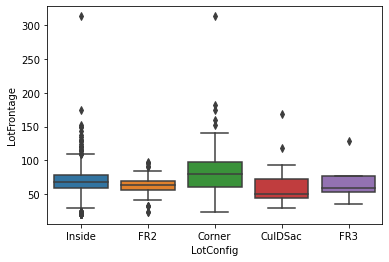

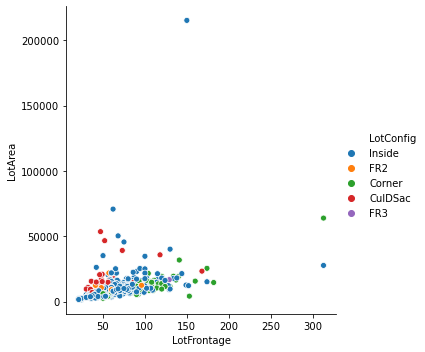

In [136]:
#Review data relation with lotfrontage
data2=data[data.LotFrontage.notnull()]

data2.corr()
sb.boxplot( y=data2["LotFrontage"], x=data2["LotConfig"] );
plt.show()
sb.relplot(x="LotFrontage", y="LotArea", hue="LotConfig",    data=data2);
plt.show()
#fill with lot config means
data['LotFrontage'] = data.groupby('LotConfig')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
#plt.scatter(data2.LotFrontage,data2.LotArea)
#plt.scatter(data.LotFrontage,data['Neighborhood'])
#data2=data._get_numeric_data()
#sb.set(style="ticks", color_codes=True)
#g = sb.pairplot(data2)
#fig, ax = plt.subplots(figsize=(20, 10))
#sb.heatmap(data.isnull(), yticklabels=False, cbar=True)
#plt.show()

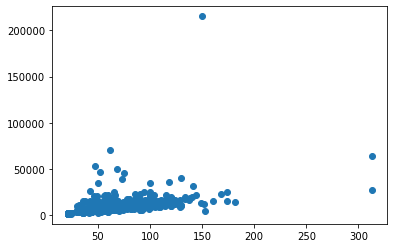

In [137]:
data=data[data['LotConfig']=='Inside']
plt.scatter(data2['LotFrontage'],data2['LotArea'])

In [138]:
# skewness along the index axis 

print(data.skew(axis = 0, skipna = True).sort_values())

#delete max outlayer in 'lotArea'
data[data['LotArea']==max(data.LotArea)]

GarageYrBlt      -3.661313
YearBuilt        -0.535178
YearRemodAdd     -0.467603
GarageCars       -0.266445
SalePriceLog     -0.084213
Id               -0.002180
FullBath          0.017586
YrSold            0.098489
OverallQual       0.181539
MoSold            0.184347
GarageArea        0.213554
BedroomAbvGr      0.287231
TotalBsmtSF       0.656078
BsmtFullBath      0.667315
TotRmsAbvGrd      0.678435
Fireplaces        0.696312
HalfBath          0.754220
OverallCond       0.798774
2ndFlrSF          0.808971
BsmtFinSF1        0.827883
BsmtUnfSF         0.942074
1stFlrSF          0.961105
GrLivArea         1.050930
MSSubClass        1.336634
WoodDeckSF        1.578922
SalePrice         1.583693
LotFrontage       2.008930
OpenPorchSF       2.463888
MasVnrArea        2.675895
EnclosedPorch     2.928103
ScreenPorch       3.973131
BsmtHalfBath      4.173185
BsmtFinSF2        4.369197
KitchenAbvGr      4.532964
LowQualFinSF      9.035263
3SsnPorch        10.753066
LotArea          16.499097
M

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePriceLog
313,314,20,RL,150.0,215245,Pave,NA,IR3,Low,AllPub,...,NA,NA,NA,0,6,2009,WD,Normal,375000,8.156325


In [139]:
data[data['LotArea']>30000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePriceLog
53,54,20,RL,68.000000,50271,Pave,NA,IR1,Low,AllPub,...,NA,NA,NA,0,11,2006,WD,Normal,385000,8.166120
313,314,20,RL,150.000000,215245,Pave,NA,IR3,Low,AllPub,...,NA,NA,NA,0,6,2009,WD,Normal,375000,8.156325
411,412,190,RL,100.000000,34650,Pave,NA,Reg,Bnk,AllPub,...,NA,NA,NA,0,1,2006,WD,Normal,145000,7.789039
451,452,20,RL,62.000000,70761,Pave,NA,IR1,Low,AllPub,...,NA,NA,NA,0,12,2006,WD,Normal,280000,8.046247
523,524,60,RL,130.000000,40094,Pave,NA,IR1,Bnk,AllPub,...,NA,NA,NA,0,10,2007,New,Partial,184750,7.885251
848,849,50,RL,75.000000,45600,Pave,NA,IR2,Bnk,AllPub,...,NA,NA,NA,0,9,2008,WD,Normal,240000,7.987158
1184,1185,20,RL,50.000000,35133,Grvl,NA,Reg,Lvl,AllPub,...,NA,NA,NA,0,5,2007,WD,Normal,186700,7.889380
1190,1191,190,RL,67.709924,32463,Pave,NA,Reg,Low,AllPub,...,NA,NA,NA,0,3,2007,WD,Normal,168000,7.847722
1287,1288,20,RL,67.709924,36500,Pave,NA,IR1,Low,AllPub,...,NA,NA,NA,0,6,2006,WD,Normal,190000,7.896263
1396,1397,20,RL,67.709924,57200,Pave,NA,IR1,Bnk,AllPub,...,NA,NA,NA,0,6,2010,WD,Normal,160000,7.828349


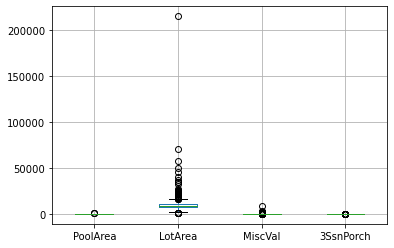

In [140]:
data.boxplot(['PoolArea','LotArea','MiscVal','3SsnPorch'])


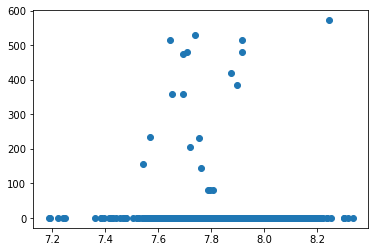

In [141]:
#delete outlayer
data=data[data.LotArea<30000]
#xt, lmbda = stats.boxcox(data["PoolArea"])
#data["PoolArea"]=xt
plt.scatter(data.SalePriceLog,data['LowQualFinSF'])

In [142]:
#Sumarizing PArameters
data['Quality'] = data['OverallQual'] + data['OverallCond']
data['builtArea'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
data['Bathrooms'] = data['FullBath'] +data['BsmtFullBath'] + (1/2 * data['BsmtHalfBath']) +  (1/2 * data['HalfBath'])

## ANOVA using OLS model
#### With this test we want to analyze the significance of the categorical parameters in our goal SalesPrice
https://www.analyticsvidhya.com/blog/2020/06/introduction-anova-statistics-data-science-covid-python/

In [151]:
data.select_dtypes(include=['object']).columns.values

array(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'], dtype=object)

In [198]:
categorical_col=data.select_dtypes(include=['object']).columns.values
df = pd.DataFrame(columns=['Categoricalparam','pvalue'])
cadena=''
for elem in categorical_col:
    cadena=cadena+'C('+elem+')+'
cadena=cadena[:-1]
cadena='C(MSZoning)'
for elem in categorical_col:
    model = ols('SalePriceLog ~C('+elem+')', data).fit()
    model.f_pvalue
    df = df.append({'Categoricalparam': elem,'pvalue':model.f_pvalue}, ignore_index=True)
df=df[(df['Categoricalparam']!='Utilities') & (df['Categoricalparam']!='LotConfig') ]
df.sort_values(by='pvalue')


#model = ols('SalePriceLog ~C('+'LotConfig'+')', data).fit()
#model.summary()) 
#model.pvalues
#fres = model.f_test()
#dir(fres)
#fres.fvalue
#fres.pvalue

,Categoricalparam,pvalue
8,Neighborhood,8.94676e-175
18,ExterQual,7.52098e-147
30,KitchenQual,2.40284e-143
21,BsmtQual,1.07448e-130
34,GarageFinish,2.24856e-113
33,GarageType,5.89623e-92
20,Foundation,5.45174e-87
32,FireplaceQu,7.22212e-75
27,HeatingQC,6.36437e-68
24,BsmtFinType1,1.06848e-62


In [183]:
#Utilities and Lot Config only has one value,and our anova pvalue test gave us a nan we will discard this columns as they are not significant.

In [172]:
#Pvalue<.05. we can reject the Null Hypothesis that there’s no difference among different  groups.

In [199]:
data corr

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,SalePriceLog,Quality,builtArea,Bathrooms
Id,1.000000,0.025433,-0.014694,0.006874,-0.043132,-0.002090,-0.019282,-0.023365,-0.078690,-0.034550,...,-0.002376,0.046649,0.036627,0.006169,0.014940,-0.049582,-0.034189,-0.036735,-0.026101,-0.002497
MSSubClass,0.025433,1.000000,-0.444436,-0.426462,0.031953,-0.049091,0.042486,0.054053,0.016452,-0.110812,...,-0.033985,-0.008400,0.019155,-0.012900,-0.000375,-0.103327,-0.091391,-0.005718,-0.121925,0.131201
LotFrontage,-0.014694,-0.444436,1.000000,0.632304,0.223781,-0.014270,0.109359,0.082071,0.168540,0.163683,...,0.076058,0.027687,0.013472,0.028753,0.009657,0.385818,0.387363,0.174258,0.398604,0.195836
LotArea,0.006874,-0.426462,0.632304,1.000000,0.161773,0.013048,-0.019087,0.014715,0.093799,0.172236,...,0.142999,0.040621,0.088727,0.012899,-0.025028,0.366933,0.359106,0.141167,0.426533,0.219306
OverallQual,-0.043132,0.031953,0.223781,0.161773,1.000000,-0.089607,0.589180,0.570450,0.391817,0.210975,...,0.082203,0.009242,-0.050988,0.073066,0.001336,0.806119,0.824125,0.761898,0.676639,0.534157
OverallCond,-0.002090,-0.049091,-0.014270,0.013048,-0.089607,1.000000,-0.428631,0.059193,-0.155708,-0.065969,...,0.061225,0.006864,0.019239,-0.018931,0.050286,-0.080310,-0.037732,0.576819,-0.143652,-0.183980
YearBuilt,-0.019282,0.042486,0.109359,-0.019087,0.589180,-0.428631,1.000000,0.604285,0.324215,0.262142,...,-0.056925,0.009174,-0.039649,0.037155,-0.011462,0.539901,0.592149,0.204484,0.372656,0.522716
YearRemodAdd,-0.023365,0.054053,0.082071,0.014715,0.570450,0.059193,0.604285,1.000000,0.179187,0.131055,...,-0.026649,0.002325,-0.044334,0.014973,0.048986,0.539904,0.584730,0.506361,0.364661,0.457914
MasVnrArea,-0.078690,0.016452,0.168540,0.093799,0.391817,-0.155708,0.324215,0.179187,1.000000,0.244899,...,0.034048,-0.002078,-0.029068,-0.002896,-0.007576,0.455606,0.408508,0.220098,0.420692,0.291251
BsmtFinSF1,-0.034550,-0.110812,0.163683,0.172236,0.210975,-0.065969,0.262142,0.131055,0.244899,1.000000,...,0.067752,0.028745,0.009257,-0.008401,0.057969,0.380607,0.368139,0.130135,0.328072,0.481676
